In [6]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 64
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 31959783.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,10,5,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(10,20,5,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(20*5*5,50),
            nn.ReLU(),
            nn.Linear(50,10)
        )
    
    def forward(self,x):
        x = self.layer(x)
        x = x.view(-1,20*5*5)
        x = self.fc_layer(x)
        return x 

In [4]:
def train_test_epochs(model, train_loader, test_loader, epochs, lr, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    model.to(device)
    model.eval()
    initial_test_loss = 0.0
    initial_test_correct = 0
    initial_test_total = 0
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Initial Test'):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            initial_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            initial_test_total += labels.size(0)
            initial_test_correct += (predicted == labels).sum().item()
    initial_test_loss /= len(test_loader)
    initial_test_accuracy = 100 * initial_test_correct / initial_test_total
    test_losses.append(initial_test_loss)
    test_accuracies.append(initial_test_accuracy)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}'), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader, desc=f'Epoch {epoch+1} Test'):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_loss /= len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    return np.array(train_losses), np.array(test_losses), np.array(train_accuracies), np.array(test_accuracies)

In [5]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_losses, test_losses, train_accuracies, test_accuracies = train_test_epochs(model, train_loader, test_loader, 10, 0.001, device)

Epoch 10 Test: 100%|██████████| 157/157 [00:01<00:00, 83.40it/s]


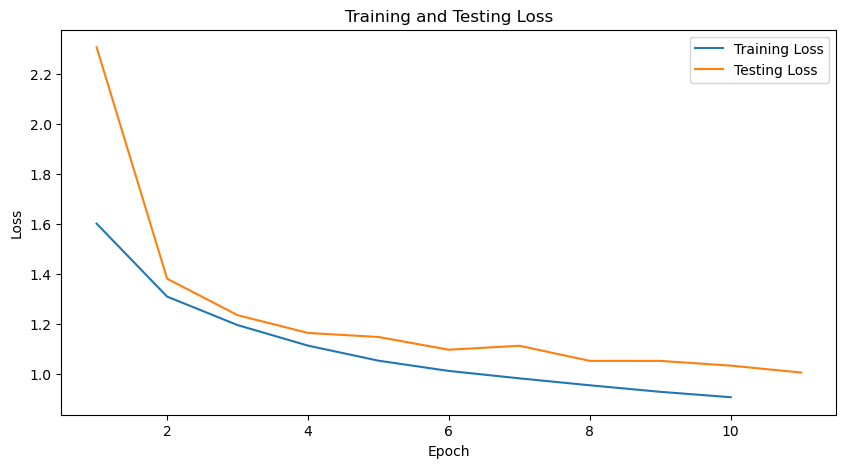

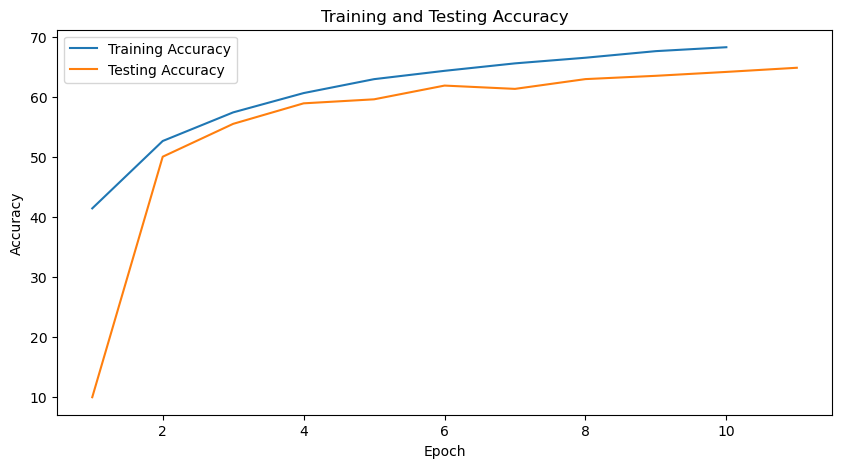

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Plotting training and testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()
